In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
raw_data = pd.read_csv('../output.csv')

In [6]:
# level 0
level_0 = ['Group','BrainSeg', 'BrainSegNotVent', 'BrainSegNotVentSurf', 
				'VentricleChoroidVol',
				'lhCortex', 'rhCortex', 'Cortex', 
				'lhCerebralWhiteMatter','rhCerebralWhiteMatter', 'CerebralWhiteMatter', 
				'SubCortGray', 'TotalGray', 
				'SupraTentorial', 'SupraTentorialNotVent', 'SupraTentorialNotVentVox',
				'Mask',	'BrainSegVol-to-eTIV', 'MaskVol-to-eTIV',
				'lhSurfaceHoles', 'rhSurfaceHoles', 'SurfaceHoles',
				'EstimatedTotalIntraCranialVol', 
				'Left-Lateral-Ventricle', 'Right-Lateral-Ventricle',
		        'Left-Inf-Lat-Vent', 'Right-Inf-Lat-Vent',
				'Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter',
		        'Left-Cerebellum-Cortex', 'Right-Cerebellum-Cortex',
				'Left-Thalamus-Proper', 'Right-Thalamus-Proper',
				'Left-Caudate', 'Right-Caudate',
		        'Left-Putamen', 'Right-Putamen',
				'Left-Pallidum', 'Right-Pallidum',
				'3rd-Ventricle', '4th-Ventricle', '5th-Ventricle',
				'Brain-Stem',
				'Left-Hippocampus', 'Right-Hippocampus',
				'Left-Amygdala', 'Right-Amygdala',
				'CSF',
				'Left-Accumbens-area', 'Right-Accumbens-area',
				'Left-VentralDC', 'Right-VentralDC',
				'Left-vessel', 'Right-vessel',
				'Left-choroid-plexus', 'Right-choroid-plexus',
				'WM-hypointensities', 'non-WM-hypointensities',
				'Optic-Chiasm',
				'CC_Posterior', 'CC_Mid_Posterior', 
				'CC_Central',
				'CC_Mid_Anterior', 'CC_Anterior']
# level 1
level_1 = ['Group', 'BrainSegNotVent', 'BrainSegNotVentSurf',
				'VentricleChoroidVol',
		        'lhCortex', 'rhCortex', 'Cortex',
				'lhCerebralWhiteMatter', 'rhCerebralWhiteMatter', 'CerebralWhiteMatter',
				'SubCortGray', 'TotalGray', 
				'BrainSegVol-to-eTIV',
		        'lhSurfaceHoles',
		        'EstimatedTotalIntraCranialVol', 
				'Left-Lateral-Ventricle', 'Right-Lateral-Ventricle',
		        'Left-Inf-Lat-Vent', 'Right-Inf-Lat-Vent',
		        'Left-Putamen', 'Right-Putamen',
				'3rd-Ventricle',
				'Left-Hippocampus', 'Right-Hippocampus',
				'Left-Amygdala', 'Right-Amygdala',
		        'Left-Accumbens-area', 'Right-Accumbens-area',
		        'WM-hypointensities', 
		        'Optic-Chiasm']
# level 2
level_2 = ['Group', 'VentricleChoroidVol',
				'lhCortex', 'rhCortex', 'Cortex',
				'SubCortGray', 'TotalGray',
				'BrainSegVol-to-eTIV',
				'lhSurfaceHoles', 
				'Left-Lateral-Ventricle', 'Right-Lateral-Ventricle',
				'Left-Inf-Lat-Vent', 'Right-Inf-Lat-Vent',
				'Left-Putamen', 'Right-Putamen',
				'3rd-Ventricle',
				'Left-Hippocampus', 'Right-Hippocampus',
				'Left-Amygdala', 'Right-Amygdala',
				'Left-Accumbens-area', 'Right-Accumbens-area',
				'WM-hypointensities']


In [14]:
roi_data = raw_data[level_0]


roi_data['Group'] = roi_data['Group'].replace('CN', 0)
roi_data['Group'] = roi_data['Group'].replace('MCI', 1)
roi_data['Group'] = roi_data['Group'].replace('AD', 2)

roi_data = roi_data.assign(Group=lambda s: s['Group'].astype('int'))
roi_data = roi_data.mask(roi_data['Group'] < 0).dropna()


features = roi_data.mask(roi_data.eq("None")).dropna().astype('float')
features_x = features[list(filter(lambda x: x != "Group", list(features.columns)))].values
features_y = features['Group'].values

<ipython-input-14-afcb59a18861>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_data['Group'] = roi_data['Group'].replace('CN', 0)
<ipython-input-14-afcb59a18861>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_data['Group'] = roi_data['Group'].replace('MCI', 1)
<ipython-input-14-afcb59a18861>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

## Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

n_fold = 10
rkf = RepeatedKFold(n_splits=n_fold, n_repeats=n_fold, random_state=777)
total_acc = 0.
rfr = []

for idx, (train_idx, test_idx) in enumerate(rkf.split(features_x)):
    train_x, test_x = features_x[train_idx], features_x[test_idx]
    train_y, test_y = features_y[train_idx], features_y[test_idx]
    
    rfr.append(RandomForestClassifier(n_estimators=5000, random_state=777).fit(train_x, train_y))
    result_rf = rfr[idx].predict(test_x)
    acc_rf = accuracy_score(test_y, result_rf)
    
    total_acc += acc_rf
    print("%f" % (acc_rf))
    
total_acc /= (n_fold*n_fold)
print("Total Acc: %f" % total_acc)

0.888889
0.902222
0.862222
0.893333
0.924444
0.897778
0.906667
0.857778
0.880000
0.920000
0.915556
0.924444
0.884444
0.880000
0.915556
0.902222
0.928889
0.920000
0.911111
0.937778
0.920000
0.906667
0.902222
0.897778
0.902222
0.906667
0.871111
0.928889
0.920000
0.902222
0.893333
0.960000
0.915556
0.893333
0.933333
0.880000
0.880000
0.902222
0.875556
0.893333
0.888889
0.915556
0.911111
0.906667
0.902222
0.915556
0.911111
0.897778
0.857778
0.888889
0.928889
0.848889
0.924444
0.911111
0.880000
0.928889
0.857778
0.911111
0.946667
0.888889
0.960000
0.893333
0.897778
0.906667
0.902222
0.862222
0.902222
0.915556
0.911111
0.911111
0.911111
0.897778
0.920000
0.880000
0.857778
0.897778
0.893333
0.911111
0.897778
0.911111
0.866667
0.831111
0.928889
0.862222
0.942222
0.893333
0.906667
0.911111
0.902222
0.920000
0.920000
0.946667
0.893333
0.920000
0.924444
0.911111
0.866667
0.888889
0.880000
0.893333
Total Acc: 0.902089


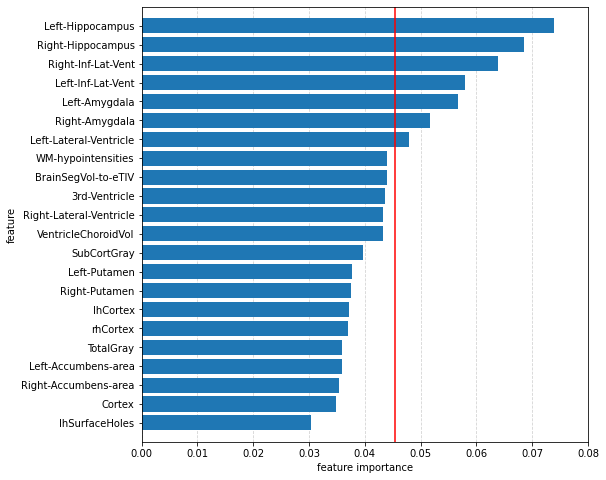

In [98]:
n_feature = 22
index = np.arange(n_feature)

feature_importances = np.array([x.feature_importances_ for x in rfr]).mean(axis=0)
_label = level_2[1:]
f = {l:d for l, d in zip(_label, feature_importances)}
f = np.array(sorted(f.items(), key=(lambda x:x[1])))
_x = f[:, 1].astype('float')
_y = f[:, 0]

plt.figure(figsize=(8, 8))
plt.barh(index, _x, align='center')
plt.yticks(index,_y)
plt.ylim(-1, n_feature)
plt.xlim(0, 0.08)
plt.xlabel('feature importance')
plt.ylabel('feature')

ax = plt.gca()
ax.xaxis.grid(True, color='lightgrey', linestyle='--')
ax.set_axisbelow(True)
plt.plot([1/n_feature, 1/n_feature], [-10, 100], color='red')

plt.savefig(str(n_feature) + '.png', dpi=300, bbox_inches='tight')
plt.show()